In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from snsphd import viz
import math
import orjson
Colors, pallet = viz.phd_style(jupyterStyle = True, grid = True, axese_width=0.5, text = 6, svg_mode=True)

from enum import Enum
from dataclasses import dataclass, fields, field, _MISSING_TYPE 

from load_schema import Decode, Result, Event

import matplotlib as mpl
import os

# set the DPI for all figures
mpl.rcParams['figure.dpi'] = 100

from snsphd.layout import bisect

from numba import njit
from snsphd.viz import save_bokeh_dark_json

In [2]:
db_values = np.arange(16,50, 2).tolist()
print(db_values)

# need type hints for intellisense to work
def decode_from_folder(folder_path: str, db_values: list[int]) -> list[Decode]:
    decodes = []
    for db in db_values:
        filename = f"decode_20GHz{db}.0.json"
        filepath = os.path.join(folder_path, filename)
        with open(filepath, "r") as f:
            data = orjson.loads(f.read())
            decode = Decode(**data)
            decodes.append(decode)
    return decodes

decodes = decode_from_folder("../inter", db_values)

[16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]


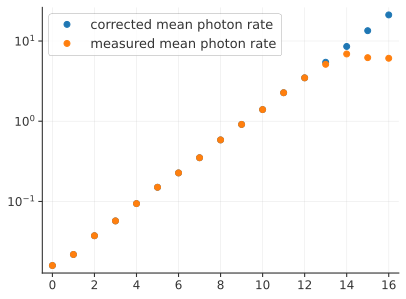

In [3]:
def calculate_mfr(struct: list[Decode]) -> list[float]:
    mfrs = []
    for d in range(len(struct)):
        missing = 0
        found = 0
        for res in struct[d].results[0]:
            result: Result = res.result
            if result == Result.MISSING:
                missing += 1
            if (result == Result.CORRECT) or (result == Result.INCORRECT):
                found += 1
        total = missing + found

        ratio_of_vacuum = missing/total
        mfr = -np.log(ratio_of_vacuum)
        mfrs.append(mfr)

    return mfrs


def calculate_corrected_mfr(struct: list[Decode]) -> list[float]:

    mfr = calculate_mfr(decodes)

    mfr = np.flip(mfr)
    ln_mfr = np.log(mfr)
    x = np.arange(len(ln_mfr))
    slope, intercept = np.polyfit(x[:-3], ln_mfr[:-3], 1)
    ln_mfr_ext = slope*x + intercept

    ln_mfr_corrected = ln_mfr.copy()
    ln_mfr_corrected[-4:] = ln_mfr_ext[-4:]
    mfr_corrected = np.exp(ln_mfr_corrected)

    plt.plot(x, mfr_corrected, 'o', label="corrected mean photon rate")
    plt.plot(x, mfr, 'o', label="measured mean photon rate")
    plt.yscale('log')
    plt.legend()

    # put the order back to what it was
    mfr = np.flip(mfr)
    mfr_corrected = np.flip(mfr_corrected)
    return mfr_corrected

mfr_corrected = calculate_corrected_mfr(decodes)

In [37]:
from gmm_solver import GMData, correction_from_gaussian_model

class Arr:
    def __init__(self):
        self.x_correct = []
        self.y_correct = []
        self.x_incorrect = []
        self.y_incorrect = []
        self.x_gaussian_fixed = []
        self.y_gaussian_fixed = []
        self.x_gaussian_corrupted = []
        self.y_gaussian_corrupted = []

    def numpyify(self):
        for item in self.__dict__:
            self.__dict__[item] = np.array(self.__dict__[item])




a = Arr()

# fig, ax = plt.subplots(1,1, figsize=(16,12))
for stream in decodes[10].results:
    for event in stream:
        if event.result == Result.CORRECT:
            a.x_correct.append(event.tag_x - 50*event.true)
            a.y_correct.append(event.tag_y - 50*event.true)

        if event.result == Result.INCORRECT:
            a.x_incorrect.append(event.tag_x - 50*event.true)
            a.y_incorrect.append(event.tag_y - 50*event.true)


        if (event.gaussian_measured != event.measured) and (event.result == Result.CORRECT):
            a.x_gaussian_fixed.append(event.tag_x - 50*event.true)
            a.y_gaussian_fixed.append(event.tag_y - 50*event.true)

        

        if (event.true == event.measured) and (event.result == Result.INCORRECT):
            a.x_gaussian_corrupted.append(event.tag_x - 50*event.true)
            a.y_gaussian_corrupted.append(event.tag_y - 50*event.true)


def decode_results(decode: Decode, slice=0, offset: float = 0.0):
    results = decode.results[slice]
    gm_data = decode.gm_data.gm_list[10]

    new_results = []
    for event in results:
        if event.result != Result.MISSING:
            # then we have data to re-analyze with the gmm and a variable offset
            gauss_correction = correction_from_gaussian_model(event.measured, (event.tag_x, event.tag_y), gm_data, laser_time=50, offset=offset)

            gaussian_measured = event.measured + gauss_correction

            if gaussian_measured == event.true:
                res = Result.CORRECT
            if gaussian_measured != event.true:
                res = Result.INCORRECT
            # else: 
            #     res = None

            new_results.append(Event(
                tag_x=event.tag_x,
                tag_y=event.tag_y,
                tag=event.tag,
                true=event.true,
                measured=event.measured,
                gaussian_measured=gaussian_measured,
                result=res
            ))
    return new_results

a.numpyify()

dB_idx = 7
recalculate_offsets = True

if recalculate_offsets == True:
    max_offsets_vs_dB = []
    for dB_idx in range(len(decodes)):
        print("dB_idx: ", dB_idx)
        decode: Decode = decodes[dB_idx]

        # print(f"mean photon rate: {mfr_corrected[dB_idx]}")

        # print(decode.gm_data.gm_list[10].num_components)

        # gm_data = decode.gm_data.gm_list[10]

        list_cc = []
        list_org_cc = []

        offsets = np.arange(-0.12, 0.02, .002).tolist()
        for offset in offsets:
            new_results = decode_results(decode, slice = 0, offset=offset)
            cc = 0
            org_cc = 0
            for event in new_results:
                if event.result == Result.CORRECT:
                    cc += 1
                if event.true == event.measured:
                    org_cc += 1
            cc = cc/len(new_results)
            org_cc = org_cc/len(new_results)
            list_cc.append(cc)
            list_org_cc.append(org_cc)
            print(f"cc: {round(cc,4)}, org_cc: {round(org_cc,4)}, offset: {offset}")
        max_offset = offsets[np.argmax(list_cc)]
        max_offsets_vs_dB.append(max_offset)

    offsets_dict = dict(max_offsets_vs_dB=max_offsets_vs_dB, db_values=db_values)
    with open("offsets.json", "w") as f:
        f.write(json.dumps(offsets_dict))
else:
    with open("offsets.json", "r") as f:
        offset_dict = json.loads(f.read())

    max_offsets_vs_dB = offset_dict["max_offsets_vs_dB"]


print(max_offsets_vs_dB)

dB_idx:  0
cc: 0.972, org_cc: 0.981, offset: -0.12
cc: 0.972, org_cc: 0.981, offset: -0.118
cc: 0.9726, org_cc: 0.981, offset: -0.11599999999999999
cc: 0.973, org_cc: 0.981, offset: -0.11399999999999999
cc: 0.9734, org_cc: 0.981, offset: -0.11199999999999999
cc: 0.974, org_cc: 0.981, offset: -0.10999999999999999
cc: 0.9744, org_cc: 0.981, offset: -0.10799999999999998
cc: 0.9747, org_cc: 0.981, offset: -0.10599999999999998
cc: 0.9751, org_cc: 0.981, offset: -0.10399999999999998
cc: 0.9753, org_cc: 0.981, offset: -0.10199999999999998
cc: 0.9761, org_cc: 0.981, offset: -0.09999999999999998
cc: 0.9762, org_cc: 0.981, offset: -0.09799999999999998
cc: 0.9766, org_cc: 0.981, offset: -0.09599999999999997


KeyboardInterrupt: 

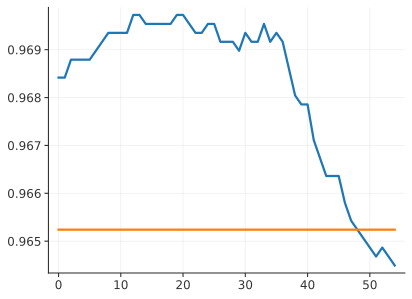

In [21]:
plt.plot(np.arange(len(list_cc)), list_cc)
plt.plot(np.arange(len(list_cc)), list_org_cc)

In [36]:
dB_idx = 6

new_results = decode_results(decodes[dB_idx], slice=0, offset=offsets[dB_idx])
cc = 0
org_cc = 0
for event in new_results:
    if event.result == Result.CORRECT:
        cc += 1
    if event.true == event.measured:
        org_cc += 1
cc = cc/len(new_results)
org_cc = org_cc/len(new_results)
print(f"cc: {round(cc,4)}, org_cc: {round(org_cc,4)}, offset: {offsets[dB_idx]}")

# not working....

cc: 0.9507, org_cc: 0.9453, offset: -0.10799999999999998


In [9]:
offsets[dB_idx]

-0.10999999999999999

In [25]:
len(decodes)

17